## Description about this notebook
This notebook is designed to visually compare the performance of our three different YOLO NAS models (Small, Medium, Large) in terms of two key metrics: Mean Average Precision at 50% (MAP50) and Mean Average Precision from 50% to 95% (MAP50:95). We employed a supervision function for this evaluation. The assessment was carried out on a test dataset, which was not previously exposed to the models. This test dataset is unique as it comprises a new blend of Jersey and Holstein cow images, captured from two distinct camera perspectives: top and side views. This setup ensures a comprehensive evaluation of the models' ability to accurately detect and recognize objects in varied and realistic scenarios.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import logging

# Set logging level to WARNING to ignore INFO messages
logging.basicConfig(level=logging.WARNING)

import os
os.environ['TORCH_HOME'] = '/home/mautushid/.torch'

#from ultralytics import NAS
os.chdir("..")
ROOT = os.getcwd()
print(ROOT)


/home/mautushid/Cowsformer


In [2]:
from models.nas import *
import pandas as pd
import matplotlib.pyplot as plt

The console stream is logged into /home/mautushid/sg_logs/console.log


[2024-02-15 14:40:12] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-15 14:40:12] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-15 14:40:18] WARNING - __init__.py - Matplotlib created a temporary cache directory at /localscratch/2081073/matplotlib-w5n7lw7f because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[2024-02-15 14:40:19] INFO - font_manager.py - generated new fontManager
[2024-02-15 14:40:24] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-15 14:40:24] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-15 14:40:24] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [3]:

# Directory containing all the checkpoints
checkpoints_dir = ROOT + "/checkpoints"

# Function to sort and organize checkpoint paths into the specified format
def organize_checkpoints_corrected(checkpoints_dir):
    # Dictionary to hold the paths categorized by category, then by type
    categorized_paths = {}

    # Iterate through each subdirectory in the checkpoints directory
    for sub_dir in os.listdir(checkpoints_dir):
        # Construct the full path of the subdirectory
        full_sub_dir_path = os.path.join(checkpoints_dir, sub_dir)
        # Check if the current path is a directory
        if os.path.isdir(full_sub_dir_path):
            # Extract category, iteration, and type from the folder name
            parts = sub_dir.split('_')
            category = parts[0]  # e.g., n10
            size_type = parts[-3][-1]  # Assuming type is represented by the last letter before the category and iteration

            # Validate size_type to be 's', 'm', or 'l'
            if size_type not in ['s', 'm', 'l']:
                continue  # Skip if size_type does not match expected values
            
            # Iterate through the RUN_... directory inside the current subdirectory
            for run_dir in os.listdir(full_sub_dir_path):
                run_dir_path = os.path.join(full_sub_dir_path, run_dir)
                if os.path.isdir(run_dir_path):
                    # Construct the path to the ckpt_best.pth file inside the RUN_... directory
                    ckpt_path = os.path.join(run_dir_path, 'ckpt_best.pth')
                    if os.path.exists(ckpt_path):
                        # Initialize the nested dictionaries and lists as needed
                        if category not in categorized_paths:
                            categorized_paths[category] = {'s': [], 'm': [], 'l': []}
                        categorized_paths[category][size_type].append(ckpt_path)

    # Sort paths within each list
    for category in categorized_paths.keys():
        for size_type in categorized_paths[category].keys():
            categorized_paths[category][size_type].sort()

    return categorized_paths

# Call the function and print the organized checkpoint paths
organized_paths = organize_checkpoints_corrected(checkpoints_dir)
for category, types in organized_paths.items():
    print(f"{category}:")
    for size_type, paths in types.items():
        print(f"  {size_type}:")
        for path in paths:
            print(f"    {path}")


n100:
  s:
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i1_exp_yolo_nas_s_100_1/RUN_20240210_204653_345192/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i2_exp_yolo_nas_s_100_2/RUN_20240211_054106_940337/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i3_exp_yolo_nas_s_100_3/RUN_20240211_145250_032070/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i4_exp_yolo_nas_s_100_4/RUN_20240212_003819_752029/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i5_exp_yolo_nas_s_100_5/RUN_20240212_100608_667624/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i6_exp_yolo_nas_s_100_6/RUN_20240212_201854_734348/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i7_exp_yolo_nas_s_100_7/RUN_20240213_064421_890665/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints/n100_yolo_na_i8_exp_yolo_nas_s_100_8/RUN_20240213_162001_606411/ckpt_best.pth
    /home/mautushid/C

In [4]:
n10_s_path = organized_paths['n10']['s']
n10_m_path = organized_paths['n10']['m']
n10_l_path = organized_paths['n10']['l']

n25_s_path = organized_paths['n200']['s']
n25_m_path = organized_paths['n200']['m']
n25_l_path = organized_paths['n200']['l']

n50_s_path = organized_paths['n200']['s']
n50_m_path = organized_paths['n200']['m']
n50_l_path = organized_paths['n200']['l']

n100_s_path = organized_paths['n200']['s']
n100_m_path = organized_paths['n200']['m']
n100_l_path = organized_paths['n200']['l']

n200_s_path = organized_paths['n200']['s']
n200_m_path = organized_paths['n200']['m']
n200_l_path = organized_paths['n200']['l']

In [12]:
path_model_s = 'yolo_nas_s'
path_model_m = 'yolo_nas_m'
path_model_l = 'yolo_nas_l'
dir_train = "/home/mautushid/Cowsformer/data/cow200/yolov5/train"
dir_val = "/home/mautushid/Cowsformer/data/cow200/yolov5/val"
dir_test = "/home/mautushid/Cowsformer/data/cow200/yolov5/test"
name_task = "cow200"
data_yaml_path = "/home/mautushid/Cowsformer/data/cow200/yolov5/data.yaml"

def evaluate_models_s(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_s, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_s, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_m(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_m, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_m, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_l(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_l, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_l, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

In [13]:
evaluattion_results_n10_s_path = evaluate_models_s(n10_s_path)
evaluattion_results_n10_m_path = evaluate_models_m(n10_m_path)
evaluattion_results_n10_l_path = evaluate_models_l(n10_l_path)

evaluattion_results_n25_s_path = evaluate_models_s(n25_s_path)
evaluattion_results_n25_m_path = evaluate_models_m(n25_m_path)
evaluattion_results_n25_l_path = evaluate_models_l(n25_l_path)

evaluattion_results_n50_s_path = evaluate_models_s(n50_s_path)
evaluattion_results_n50_m_path = evaluate_models_m(n50_m_path)
evaluattion_results_n50_l_path = evaluate_models_l(n50_l_path)

evaluattion_results_n100_s_path = evaluate_models_s(n100_s_path)
evaluattion_results_n100_m_path = evaluate_models_m(n100_m_path)
evaluattion_results_n100_l_path = evaluate_models_l(n100_l_path)

evaluattion_results_n200_s_path = evaluate_models_s(n200_s_path)
evaluattion_results_n200_m_path = evaluate_models_m(n200_m_path)
evaluattion_results_n200_l_path = evaluate_models_l(n200_l_path)

[2024-02-15 16:50:00] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-15 16:50:00] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-02-15 16:50:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i10_exp_yolo_nas_s_10_10/RUN_20240214_054002_816430/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i1_exp_yolo_nas_s_10_1/RUN_20240210_152123_154543/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i2_exp_yolo_nas_s_10_2/RUN_20240211_002557_041887/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i3_exp_yolo_nas_s_10_3/RUN_20240211_091223_994052/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i4_exp_yolo_nas_s_10_4/RUN_20240211_184217_121750/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:04] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i5_exp_yolo_nas_s_10_5/RUN_20240212_042019_800251/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:04] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i6_exp_yolo_nas_s_10_6/RUN_20240212_140423_665237/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:05] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i7_exp_yolo_nas_s_10_7/RUN_20240213_003131_796007/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:05] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i8_exp_yolo_nas_s_10_8/RUN_20240213_103247_000860/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:06] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i9_exp_yolo_nas_s_10_9/RUN_20240213_201258_704919/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:50:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:09] INFO -

[2024-02-15 16:50:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:21] INFO -

[2024-02-15 16:50:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:36] INFO -

[2024-02-15 16:50:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:49] INFO -

[2024-02-15 16:50:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:50:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:01] INFO -

[2024-02-15 16:51:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:23] INFO -

[2024-02-15 16:51:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:35] INFO -

[2024-02-15 16:51:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:47] INFO -

[2024-02-15 16:51:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:51:59] INFO -

model yolo_nas_m loaded


[2024-02-15 16:52:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i1_exp_yolo_nas_m_10_1/RUN_20240210_154548_734483/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i2_exp_yolo_nas_m_10_2/RUN_20240211_005151_442880/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:12] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i3_exp_yolo_nas_m_10_3/RUN_20240211_093644_134143/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i4_exp_yolo_nas_m_10_4/RUN_20240211_191107_542564/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i5_exp_yolo_nas_m_10_5/RUN_20240212_044518_030572/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i6_exp_yolo_nas_m_10_6/RUN_20240212_143253_264317/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i7_exp_yolo_nas_m_10_7/RUN_20240213_010103_616519/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i8_exp_yolo_nas_m_10_8/RUN_20240213_105924_301812/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i9_exp_yolo_nas_m_10_9/RUN_20240213_203820_268649/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 16:52:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:20] INFO -

[2024-02-15 16:52:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:52:54] INFO -

[2024-02-15 16:53:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:11] INFO -

[2024-02-15 16:53:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:28] INFO -

[2024-02-15 16:53:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:53:50] INFO -

[2024-02-15 16:54:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:13] INFO -

[2024-02-15 16:54:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:54:39] INFO -

[2024-02-15 16:55:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:16] INFO -

[2024-02-15 16:55:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:55:33] INFO -

model yolo_nas_l loaded


[2024-02-15 16:55:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i1_exp_yolo_nas_l_10_1/RUN_20240210_162416_555023/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:55:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i2_exp_yolo_nas_l_10_2/RUN_20240211_013005_563379/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:55:54] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i3_exp_yolo_nas_l_10_3/RUN_20240211_101838_443837/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:55:55] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i4_exp_yolo_nas_l_10_4/RUN_20240211_195313_152577/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:55:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i5_exp_yolo_nas_l_10_5/RUN_20240212_052426_079800/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:55:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i6_exp_yolo_nas_l_10_6/RUN_20240212_151607_056335/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:55:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i7_exp_yolo_nas_l_10_7/RUN_20240213_014449_611517/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:56:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i8_exp_yolo_nas_l_10_8/RUN_20240213_114023_538025/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:56:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n10_yolo_na_i9_exp_yolo_nas_l_10_9/RUN_20240213_211918_966499/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 16:56:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:04] INFO -

[2024-02-15 16:56:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:23] INFO -

[2024-02-15 16:56:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:56:47] INFO -

[2024-02-15 16:57:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:29] INFO -

[2024-02-15 16:57:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:57:55] INFO -

[2024-02-15 16:58:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:17] INFO -

[2024-02-15 16:58:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:58:59] INFO -

[2024-02-15 16:59:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:22] INFO -

[2024-02-15 16:59:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 16:59:43] INFO -

model yolo_nas_s loaded


[2024-02-15 16:59:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240211_072732_141903/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:59:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240211_164322_233328/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 16:59:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240212_023005_576928/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:00:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240212_120309_935983/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:00:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240212_222331_382610/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:00:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240213_084554_572418/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:00:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240213_181621_173318/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:00:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_s_200_9/RUN_20240214_034953_561685/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:00:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:04] INFO -

[2024-02-15 17:00:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:23] INFO -

[2024-02-15 17:00:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:00:43] INFO -

[2024-02-15 17:01:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:08] INFO -

[2024-02-15 17:01:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:30] INFO -

[2024-02-15 17:01:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:48] INFO -

[2024-02-15 17:01:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:01:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:01] INFO -

[2024-02-15 17:02:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:13] INFO -

[2024-02-15 17:02:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_m_200_1/RUN_20240210_230147_031265/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240211_075116_371955/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240211_171114_442948/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240212_025553_642448/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240212_123104_230704/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240212_225245_627953/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240213_091103_422165/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240213_184230_876445/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_m_200_9/RUN_20240214_041441_133794/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:02:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:02:52] INFO -

[2024-02-15 17:03:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:13] INFO -

[2024-02-15 17:03:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:31] INFO -

[2024-02-15 17:03:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:03:52] INFO -

[2024-02-15 17:04:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:10] INFO -

[2024-02-15 17:04:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:29] INFO -

[2024-02-15 17:04:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:04:47] INFO -

[2024-02-15 17:05:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:13] INFO -

[2024-02-15 17:05:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_l_200_1/RUN_20240210_234009_601543/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240211_082726_071031/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240211_175315_203990/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240212_033431_718908/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240212_131504_779374/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240212_233744_965963/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240213_094803_509650/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240213_192353_748376/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_l_200_9/RUN_20240214_045429_115100/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:05:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:05:42] INFO -

[2024-02-15 17:06:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:09] INFO -

[2024-02-15 17:06:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:30] INFO -

[2024-02-15 17:06:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:06:51] INFO -

[2024-02-15 17:07:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:11] INFO -

[2024-02-15 17:07:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:31] INFO -

[2024-02-15 17:07:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:07:54] INFO -

[2024-02-15 17:08:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:14] INFO -

[2024-02-15 17:08:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_s_200_1/RUN_20240210_223653_700133/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240211_072732_141903/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240211_164322_233328/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240212_023005_576928/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240212_120309_935983/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240212_222331_382610/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240213_084554_572418/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240213_181621_173318/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_s_200_9/RUN_20240214_034953_561685/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:08:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:38] INFO -

[2024-02-15 17:08:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:08:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:01] INFO -

[2024-02-15 17:09:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:14] INFO -

[2024-02-15 17:09:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:26] INFO -

[2024-02-15 17:09:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:38] INFO -

[2024-02-15 17:09:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:09:56] INFO -

[2024-02-15 17:10:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:10] INFO -

[2024-02-15 17:10:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:23] INFO -

[2024-02-15 17:10:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_m_200_1/RUN_20240210_230147_031265/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240211_075116_371955/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240211_171114_442948/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240212_025553_642448/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240212_123104_230704/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240212_225245_627953/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240213_091103_422165/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240213_184230_876445/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:46] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_m_200_9/RUN_20240214_041441_133794/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:10:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:10:48] INFO -

[2024-02-15 17:11:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:05] INFO -

[2024-02-15 17:11:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:25] INFO -

[2024-02-15 17:11:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:11:51] INFO -

[2024-02-15 17:12:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:09] INFO -

[2024-02-15 17:12:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:33] INFO -

[2024-02-15 17:12:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:12:50] INFO -

[2024-02-15 17:13:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:13:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:13:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:13:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:13:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:13:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:13:24] INFO -

[2024-02-15 17:13:50] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_l_200_1/RUN_20240210_234009_601543/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240211_082726_071031/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240211_175315_203990/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240212_033431_718908/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:54] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240212_131504_779374/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:56] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240212_233744_965963/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240213_094803_509650/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240213_192353_748376/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_l_200_9/RUN_20240214_045429_115100/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:13:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:02] INFO -

[2024-02-15 17:14:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:25] INFO -

[2024-02-15 17:14:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:14:56] INFO -

[2024-02-15 17:15:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:16] INFO -

[2024-02-15 17:15:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:15:41] INFO -

[2024-02-15 17:16:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:02] INFO -

[2024-02-15 17:16:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:27] INFO -

[2024-02-15 17:16:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:16:58] INFO -

[2024-02-15 17:17:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_s_200_1/RUN_20240210_223653_700133/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240211_072732_141903/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240211_164322_233328/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240212_023005_576928/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240212_120309_935983/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240212_222331_382610/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240213_084554_572418/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240213_181621_173318/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:27] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_s_200_9/RUN_20240214_034953_561685/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:17:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:29] INFO -

[2024-02-15 17:17:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:42] INFO -

[2024-02-15 17:17:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:17:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:00] INFO -

[2024-02-15 17:18:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:17] INFO -

[2024-02-15 17:18:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:30] INFO -

[2024-02-15 17:18:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:42] INFO -

[2024-02-15 17:18:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:18:55] INFO -

[2024-02-15 17:19:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:23] INFO -

[2024-02-15 17:19:47] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_m_200_1/RUN_20240210_230147_031265/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240211_075116_371955/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:49] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240211_171114_442948/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:50] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240212_025553_642448/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240212_123104_230704/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240212_225245_627953/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240213_091103_422165/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:54] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240213_184230_876445/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:55] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_m_200_9/RUN_20240214_041441_133794/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:19:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:19:59] INFO -

[2024-02-15 17:20:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:23] INFO -

[2024-02-15 17:20:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:20:49] INFO -

[2024-02-15 17:21:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:06] INFO -

[2024-02-15 17:21:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:42] INFO -

[2024-02-15 17:21:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:21:59] INFO -

[2024-02-15 17:22:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:17] INFO -

[2024-02-15 17:22:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:22:51] INFO -

[2024-02-15 17:23:09] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_l_200_1/RUN_20240210_234009_601543/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240211_082726_071031/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240211_175315_203990/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240212_033431_718908/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240212_131504_779374/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240212_233744_965963/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240213_094803_509650/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240213_192353_748376/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_l_200_9/RUN_20240214_045429_115100/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:23:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:23:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:23:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:23:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:23:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:23:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:23:21] INFO -

[2024-02-15 17:24:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:17] INFO -

[2024-02-15 17:24:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:24:53] INFO -

[2024-02-15 17:25:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:24] INFO -

[2024-02-15 17:25:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:25:50] INFO -

[2024-02-15 17:26:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:10] INFO -

[2024-02-15 17:26:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:30] INFO -

[2024-02-15 17:26:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:26:56] INFO -

[2024-02-15 17:27:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_s_200_1/RUN_20240210_223653_700133/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240211_072732_141903/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240211_164322_233328/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240212_023005_576928/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240212_120309_935983/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240212_222331_382610/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240213_084554_572418/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240213_181621_173318/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_s_200_9/RUN_20240214_034953_561685/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 17:27:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:20] INFO -

[2024-02-15 17:27:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:32] INFO -

[2024-02-15 17:27:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:27:44] INFO -

[2024-02-15 17:28:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:13] INFO -

[2024-02-15 17:28:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:28:41] INFO -

[2024-02-15 17:29:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:29:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:29:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:29:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:29:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:29:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:29:56] INFO -

[2024-02-15 17:30:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:22] INFO -

[2024-02-15 17:30:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:30:42] INFO -

[2024-02-15 17:30:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_m_200_1/RUN_20240210_230147_031265/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:30:54] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240211_075116_371955/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:30:55] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240211_171114_442948/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:30:56] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240212_025553_642448/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:30:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240212_123104_230704/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:30:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240212_225245_627953/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:30:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240213_091103_422165/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:31:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240213_184230_876445/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:31:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_m_200_9/RUN_20240214_041441_133794/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 17:31:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:31:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:31:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:31:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:31:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:31:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:31:03] INFO -

[2024-02-15 17:32:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:11] INFO -

[2024-02-15 17:32:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:32:54] INFO -

[2024-02-15 17:33:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:28] INFO -

[2024-02-15 17:33:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:33:57] INFO -

[2024-02-15 17:34:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:16] INFO -

[2024-02-15 17:34:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:34:37] INFO -

[2024-02-15 17:35:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:14] INFO -

[2024-02-15 17:35:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i1_exp_yolo_nas_l_200_1/RUN_20240210_234009_601543/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240211_082726_071031/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240211_175315_203990/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240212_033431_718908/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240212_131504_779374/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240212_233744_965963/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240213_094803_509650/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240213_192353_748376/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n200_yolo_na_i9_exp_yolo_nas_l_200_9/RUN_20240214_045429_115100/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 17:35:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:35:48] INFO -

[2024-02-15 17:36:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:09] INFO -

[2024-02-15 17:36:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:31] INFO -

[2024-02-15 17:36:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:36:53] INFO -

[2024-02-15 17:37:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:37:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:37:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:37:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:37:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:37:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:37:36] INFO -

[2024-02-15 17:38:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:05] INFO -

[2024-02-15 17:38:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:26] INFO -

[2024-02-15 17:38:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 17:38:46] INFO -

In [15]:
import numpy as np

# Extracting mAP@50 and mAP@50:95 values
map50_values = [result['mAP@50'] for result in evaluattion_results_n100_l_path]
map5095_values = [result['mAP@50:95'] for result in evaluattion_results_n100_l_path]

# Calculating medians
median_map50 = np.median(map50_values)
median_map5095 = np.median(map5095_values)

median_map50, median_map5095



(0.9535102663515862, 0.7186673595637707)

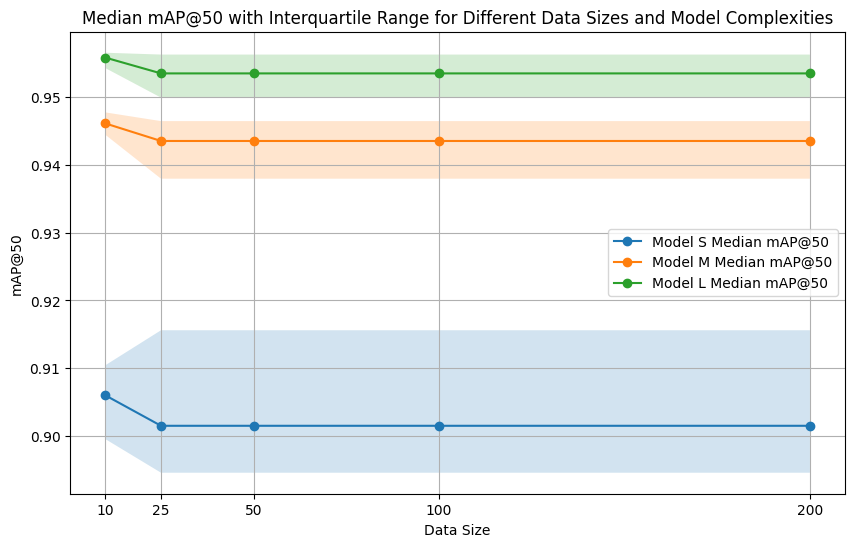

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the actual evaluation data in these variables
# Replace these lines with your actual evaluation data
evaluation_results_n10_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]



# Collect all the results in a dictionary for processing
evaluation_results = {
    'n10_s': evaluattion_results_n10_s_path,
    'n10_m': evaluattion_results_n10_m_path,
    'n10_l': evaluattion_results_n10_l_path,
    'n25_s': evaluattion_results_n25_s_path,
    'n25_m': evaluattion_results_n25_m_path,
    'n25_l': evaluattion_results_n25_l_path,
    'n50_s': evaluattion_results_n50_s_path,
    'n50_m': evaluattion_results_n50_m_path,
    'n50_l': evaluattion_results_n50_l_path,
    'n100_s': evaluattion_results_n100_s_path,
    'n100_m': evaluattion_results_n100_m_path,
    'n100_l': evaluattion_results_n100_l_path,
    'n200_s': evaluattion_results_n200_s_path,
    'n200_m': evaluattion_results_n200_m_path,
    'n200_l': evaluattion_results_n200_l_path,
    
}

# Calculate statistics for each combination of dataset size and model complexity
evaluation_statistics = {}
for key, results in evaluation_results.items():
    map50_scores = [res['mAP@50'] for res in results]
    median_map50 = np.median(map50_scores)
    q1_map50 = np.percentile(map50_scores, 25)
    q3_map50 = np.percentile(map50_scores, 75)
    
    evaluation_statistics[key] = {
        'median': median_map50,
        'q1': q1_map50,
        'q3': q3_map50
    }

# Sort the keys to make sure the data sizes are in order (from smallest to largest dataset size)
sorted_keys = sorted(evaluation_statistics, key=lambda x: (int(x[1:x.index('_')]), x[-1]))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the median values and fill the area between Q1 and Q3
for model_size in ['s', 'm', 'l']:  # For each model size
    data_sizes = [int(key[1:key.index('_')]) for key in sorted_keys if key.endswith(model_size)]
    median_values = [evaluation_statistics[key]['median'] for key in sorted_keys if key.endswith(model_size)]
    q1_values = [evaluation_statistics[key]['q1'] for key in sorted_keys if key.endswith(model_size)]
    q3_values = [evaluation_statistics[key]['q3'] for key in sorted_keys if key.endswith(model_size)]

    # Plot the median line
    ax.plot(data_sizes, median_values, marker='o', label=f'Model {model_size.upper()} Median mAP@50')
    
    # Fill the area between Q1 and Q3 for the interquartile range
    ax.fill_between(data_sizes, q1_values, q3_values, alpha=0.2)

# Customize the plot
ax.set_title('Median mAP@50 with Interquartile Range for Different Data Sizes and Model Complexities')
ax.set_xlabel('Data Size')
ax.set_ylabel('mAP@50')
ax.set_xticks(sorted(set(data_sizes))) # Set x-ticks to unique sorted data sizes
ax.legend()
ax.grid(True)

# Show the plot
plt.show()
